In [168]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''') 

# <font color="#E56717">IOBS & IBA Project Update</font>

# <font color="#E56717">October 2016</font>

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

In [170]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

# <font color="#E56717">First order of business is to identify all the patients in the SEER-Medicare data who have revceived PBT</font>

<span style="font-size:1.5em;">The relevant HCPCS codes are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simle w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>

# <font color="#E56717">Use the Outpatient Claims and Carrier Claims files</font>

* <span style="font-size:1.5em;">218 Outpatient Claims files</span>
* <span style="font-size:1.5em;">207 Carrier Claims files</span>

<span style="font-size:1.5em;">Loop through all of these files and capture the set of all the patient_id s corresponding to teh PBT HCPCS codes</span>

## <font color="#E56717">Result:</font>

* <span style="font-size:1.5em;">1605 unique PBT patients appear in the claims files for claims in years 2006-2013</span>

In [171]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [172]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [173]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [174]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [175]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [176]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [177]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
#len(treatmentindices)

In [178]:
len(set(treatmentindices))

1605

# <font color="#E56717">Next step is to identify the patients in the SEER-Medicare data who have received any other form of RT</font>

<span style="font-size:1.5em;">Identifying these patients via the SEER data alone proved problematic; half of these patients did not have RT code signatures in the Medicare data.</span>

## <font color="#E56717">Use the following RT treatment delivery codes:</font>

<span style="font-size:1.3em;">['77401','77402','77403','77404','77405','77406','77407','77408','77409','77410','77411','77412','77413',
 '77414','77415','77416','77417','77418','77419','77420','77421','77422','77423','77424','77425','77521',
 '77524','77750','77751','77752','77753','77754','77755','77756','77757','77758','77759','77760','77761',
 '77762','77763','77764','77765','77766','77767','77768','77769','77770','77771','77772','77773','77774',
 '77775','77776','77777','77778','77779','77780','77781','77782','77783','77784','77785','77786','77787',
 '77788','77789','77790','77791','77792','77793','77794','77795','77796','77797','77798','77799','G0173',
 'G0251','G0256','G0261','G0339','G0340']</span>

In [179]:
import pickle
fileObject = open('control_patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_outsaf = list(set.union(*b))

In [180]:
import pickle
fileObject = open('control_patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_nch = list(set.union(*b))

In [181]:
bigcontrolindices = list(set(controlindices_nch+controlindices_outsaf))

In [182]:
bigcontrolset = set(bigcontrolindices)
allset = set(allindices)


allcontrolindices = list(allset.intersection(bigcontrolset))

controlindices = allcontrolindices
#len(treatmentindices)

In [183]:
len(controlindices)

177154

# <font color="#E56717">175878 unique patients had those RT treatment delivery codes (and did not have any PBT codes)</font>


In [184]:
len(treatmentindices)

1605

In [185]:
purecontrolindices = list(set(controlindices) - set(treatmentindices))
len(purecontrolindices)

175878

In [186]:
len(controlindices) - len(purecontrolindices)

1276

# <font color="#E56717">Now use the pedsf files to perform patient matching, using the patient_id s found above</font>

<span style="font-size:1.5em;">List of pedsf files (contains SEER diagnosis year dates 2006-2011):</span>

* pedsf.nasopharynx.cancer.txt
* pedsf.salivary.cancer.txt
* pedsf.oropharynx.cancer.txt
* pedsf.esophagus.cancer.txt
* pedsf.brain.cancer.txt
* pedsf.eyeandorbit.cancer.txt
* pedsf.softtissue.cancer.txt
* pedsf.prostate.cancer.file01.txt
* pedsf.prostate.cancer.file02.txt
* pedsf.prostate.cancer.file03.txt
* pedsf.lung.cancer.file01.txt
* pedsf.lung.cancer.file02.txt
* pedsf.breast.cancer.file01.txt
* pedsf.breast.cancer.file02.txt


# <font color="#E56717">The pedsf files contain one single row for each patient, and contain information for up to 10 different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

In [187]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the file pedsf.salivarygland.cancer.txt, the cancer sites for the first tumor listed for each patient has the following distribution:</span>

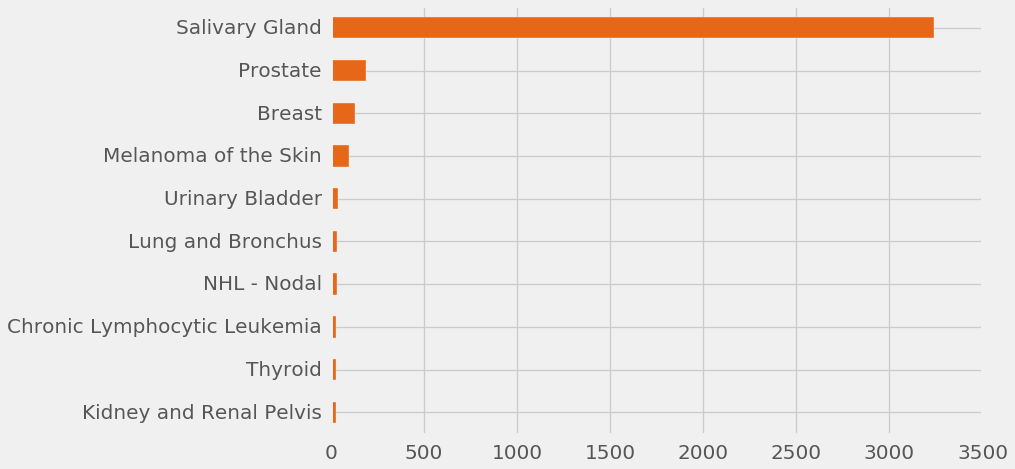

In [188]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

# <font color="#E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing.
Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis as indicated by the SEER data.</span>

In [189]:
dfall.patient_id.isin(treatmentindices).sum()

1605

In [190]:
dfall.patient_id.isin(purecontrolindices).sum()

175878

In [191]:
dfall.shape

(719821, 496)

In [192]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

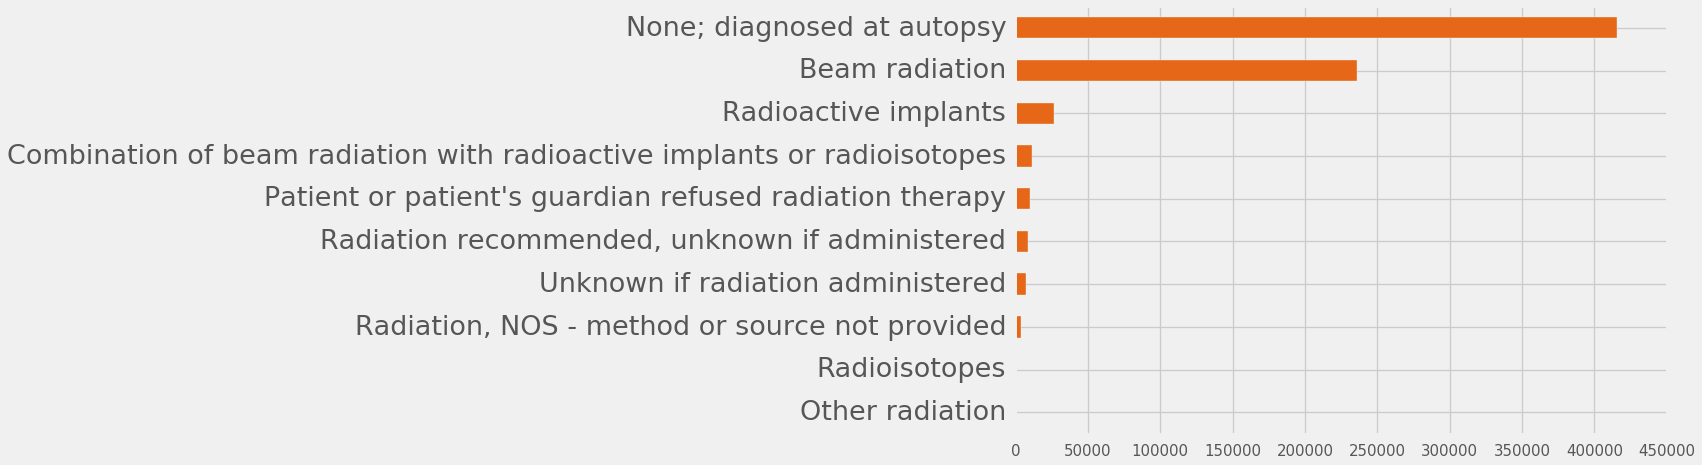

In [193]:
import mpld3
mpld3.disable_notebook()
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)
#plt.tick_params(labelsize=27) # remove the None, refused and unknown group

In [194]:
one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()



In [195]:
dfsmall.shape

(278330, 496)

In [196]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(treatmentindices)].index
smallcontrolindices = dfsmall[dfsmall.patient_id.isin(purecontrolindices)].index

In [197]:
smallcontrolindices.shape

(131038,)

In [198]:
smalltreatmentindices.shape


(1200,)

In [199]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()

In [200]:
dfalltreatment.shape, dfallcontrol.shape

((1200, 496), (131038, 496))

# <font color="#E56717">So we are going to match patients who have received PBT (1200 of them) with one of the 131038 patients who have received some other form of radiation. These patients have been identified as receiving RT treatment delivery in both halves of the SEER-Medicare data</font>

<span style="font-size:1.5em;">We first need to decide on which features (or columns) ofthe data to use to define the feature space; and then do some preprocessing of this data ("one-hot-encode" the categorical features)</span>

In [201]:
dfsmall.columns

Index(['casereg', 'patient_id', 'casenumber', 'fivepct', 'medicaredateofdeath',
       'birthm', 'birthyr', 'm_sex', 'race', 'state',
       ...
       'icdot09_1_description', 'icdot09_2_description',
       'icdot09_3_description', 'icdot09_4_description',
       'icdot09_5_description', 'icdot09_6_description',
       'icdot09_7_description', 'icdot09_8_description',
       'icdot09_9_description', 'icdot09_10_description'],
      dtype='object', length=496)

In [202]:
cstum1mask =  (dfsmall['cstum1'] != "Unknown; size not stated; not stated in patient record") & \
(dfsmall['cstum1'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfsmall['cstum1'] != "989 millimeters or larger") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != "Unknown age") & \
(dfsmall['cstum1'] != "Described as less than 1 cm") & \
(dfsmall['cstum1'] != "Described as less than 2 cm") & \
(dfsmall['cstum1'] != "Described as less than 3 cm") & \
(dfsmall['cstum1'] != 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfsmall['cstum1'] != "Described as less than 4 cm") & \
(dfsmall['cstum1'] != "Described as less than 5 cm") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != 'Not applicable') & \
(dfsmall['cstum1'] != 996) & \
(dfsmall['cstum1'] != 997) & \
(dfsmall['cstum1'] != 998) & \
(dfsmall['srvm1'] != 9999)

# <font color="#E56717">We will not include the variable **cstum1** (the tumor size in mm) for the following reasons:</font>

* <span style="font-size:1.5em;">Egregious measurement error, plots to follow for lung and prostate</span>
* <span style="font-size:1.5em;">Over half of the patients hav emissing values, or text values instead of numbers
    * "Unknown; size not stated; not stated in patient record"
    * "Microscopic focus or foci only; no size of focus is given"
    * "989 millimeters or larger"
    * "Not applicable"
    * "Described as less than 1 cm"
    * "Described as less than 2 cm"
    * "Described as less than 3 cm"
    * 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized'
    * "Described as less than 4 cm"
    * "Described as less than 5 cm"</span>

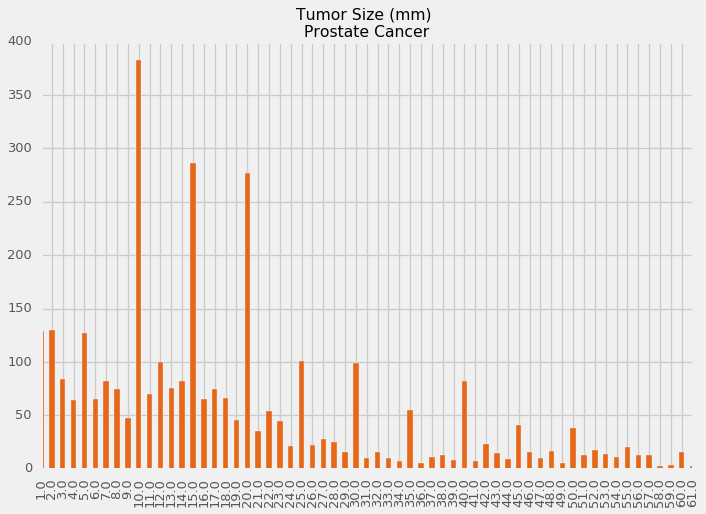

In [203]:
dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nProstate Cancer',color='#E56717');
plt.xlim(0,60);

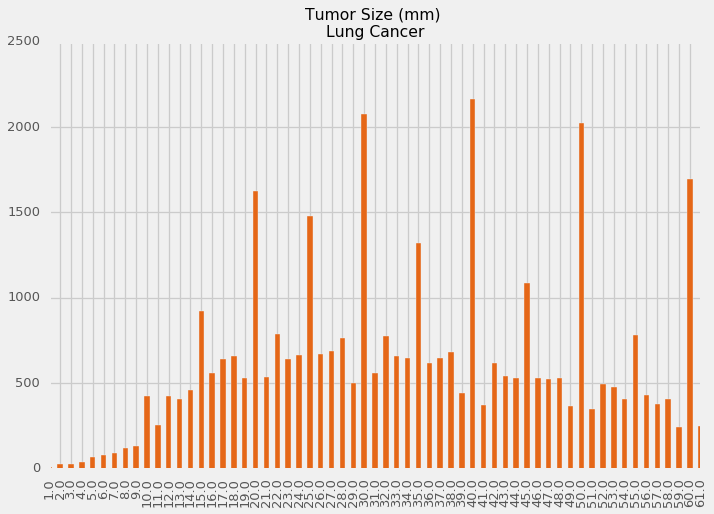

In [204]:
fig1 = plt.figure()
ax = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nLung Cancer',color='#E56717');
plt.xlim(0,60);

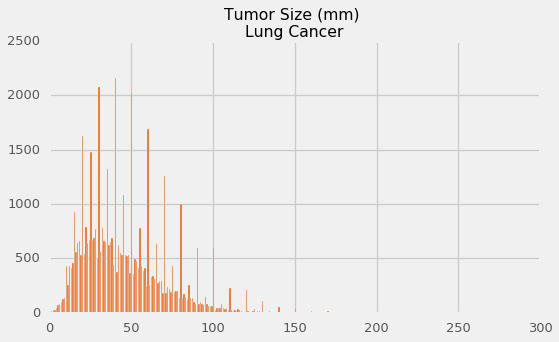

In [205]:
import mpld3
fig, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,300)
plt.title('Tumor Size (mm) \nLung Cancer')
plt.tight_layout()
plt.show()

In [206]:
mpld3.disable_notebook()
mpld3.display(fig)

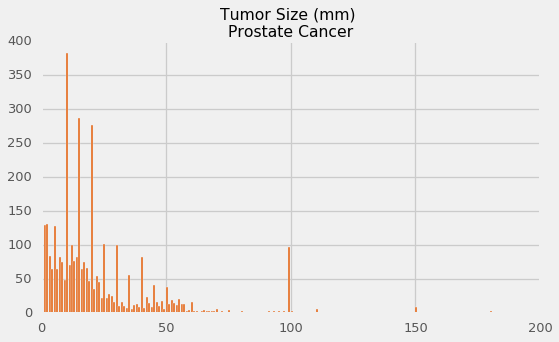

In [207]:
figp, ax = plt.subplots(figsize=(8,5))
huh = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index()
xvalues = huh.index
yvalues = huh.values

rects = ax.bar(xvalues,yvalues,color='#E56717')
plt.xlim(0,200)
plt.title("Tumor Size (mm) \nProstate Cancer")
plt.tight_layout()
plt.show()

In [208]:
mpld3.display(figp)

# <font color="#E56717">This phenomena is so common (incluidng in medicine) it has a name</font>

## End-digit preference

<span style="font-size:1.5em;">"In converting analog to digital data, observers may record some terminal digits with an unusual frequency, for example rounding off may be to the nearest whole number, even number, multiple of 5 or 10, or when time units like a week are involved, 7, 14, etc."</span>

* <span style="font-size:1.2em;">Encyclopedia of Epidemiologic Methods, by By Mitchell H. Gail, Jacques Benichou</span>

In [209]:
catcols = ['m_sex','marst1','srace','nhiade','grade1',
           'site1','lat1',
          'histrec1',
           'modx1','stat_rec']


goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1',
           'lat1','histrec1',
           'modx1','stat_rec','birthyr',
           'agedx1',
           'yrdx1','elevation_1',
           'lng_1','lat_1']

In [210]:
dfpop = pd.concat([dfallcontrol, dfalltreatment])


In [211]:
resgoodcontrol = pd.concat([pd.get_dummies(dfallcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfalltreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

In [212]:
print(goodcols)

['m_sex', 'marst1', 'srace', 'nhiade', 'grade1', 'site1', 'lat1', 'histrec1', 'modx1', 'stat_rec', 'birthyr', 'agedx1', 'yrdx1', 'elevation_1', 'lng_1', 'lat_1']


In [213]:
resgoodcontrol['birthyr'] = dfallcontrol['birthyr']
resgoodcontrol['agedx1'] = dfallcontrol['agedx1']

resgoodcontrol['yrdx1'] = dfallcontrol['yrdx1']


resgoodcontrol['lat_1'] = dfallcontrol['lat_1']

resgoodcontrol['lng_1'] = dfallcontrol['lng_1']

resgoodcontrol['srvm1'] = dfallcontrol['srvm1']

resgoodcontrol['elevation_1'] = dfallcontrol['elevation_1']

In [214]:
resgoodtreatment['birthyr'] = dfalltreatment['birthyr']
resgoodtreatment['agedx1'] = dfalltreatment['agedx1']

resgoodtreatment['yrdx1'] = dfalltreatment['yrdx1']


resgoodtreatment['lat_1'] = dfalltreatment['lat_1']

resgoodtreatment['lng_1'] = dfalltreatment['lng_1']

resgoodtreatment['srvm1'] = dfalltreatment['srvm1']

resgoodtreatment['elevation_1'] = dfalltreatment['elevation_1']

In [215]:
resgoodpop['birthyr'] = dfpop['birthyr']
resgoodpop['agedx1'] = dfpop['agedx1']

resgoodpop['yrdx1'] = dfpop['yrdx1']




resgoodpop['lat_1'] = dfpop['lat_1']

resgoodpop['lng_1'] = dfpop['lng_1']

resgoodpop['srvm1'] = dfpop['srvm1']

resgoodpop['elevation_1'] = dfpop['elevation_1']

# <font color="#E56717">After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

<span style="font-size:1.5em;">Below is how it looks before matching patients in the control and treatment groups together in pairs</span>

In [216]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[smallcontrolindices]["srvm1"]
Econtrol = resgoodpop.loc[smallcontrolindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[smalltreatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[smalltreatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All Radiation group');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='Non PBT group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='PBT group (treatment group)')

<lifelines.KaplanMeierFitter: fitted with 1200 observations, 1051 censored>

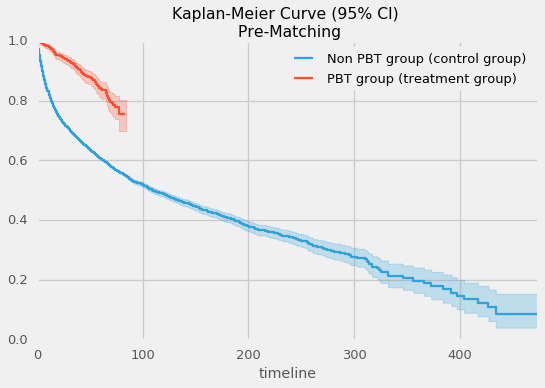

In [217]:
mpld3.enable_notebook()
ax = kmfcontrol.plot(figsize=(8,5))
kmftreatment.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Pre-Matching");

In [218]:
mpld3.disable_notebook()

# <font color="#E56717">Clearly, there is a difference between these survival curves</font>

<span style="font-size:1.5em;">But one can argue that we are not really comparing apples to apples when we calculate these two survival curves. To answer this objection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the difference in treatment modalites.</span>

In [219]:
resgoodpop['birthyr'] = resgoodpop['birthyr'].astype('int')
resgoodpop['agedx1'] = resgoodpop['agedx1'].astype('float')



resgoodpop['lat_1'] = resgoodpop['lat_1'].astype('float')



resgoodpop['lng_1'] = resgoodpop['lng_1'].astype('float')
resgoodpop['elevation_1'] = resgoodpop['elevation_1'].astype('float')

resgoodpop['srvm1'] = resgoodpop['srvm1'].astype('float')


newcolumns = list(resgoodpop.columns)

newcolumns.remove('srvm1')
newcolumns.remove('stat_rec_Alive')
newcolumns.remove('stat_rec_Dead')
newcolumns.remove('m_sex_Male')

resgreatpop = resgoodpop[newcolumns].copy()

In [220]:
resgreatpop['patient_id'] = resgreatpop.index
leaguefilter = (resgreatpop['patient_id'].loc[smalltreatmentindices])
resgreatpop['League'] = resgreatpop['patient_id'].isin(smalltreatmentindices).astype('int')
del resgreatpop['patient_id']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [221]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

In [222]:
print(list(dftree.columns))

['m_sex_Female', 'marst1_Divorced', 'marst1_Married (including common law)', 'marst1_Separated', 'marst1_Single (never married)', 'marst1_Unknown', 'marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered)', 'marst1_Widowed', 'srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)', 'srace_Asian Indian', 'srace_Asian Indian or Pakistani, NOS', 'srace_Black', 'srace_Chamorran', 'srace_Chinese', 'srace_Fiji Islander', 'srace_Filipino', 'srace_Guamanian, NOS', 'srace_Hawaiian', 'srace_Hmong', 'srace_Japanese', 'srace_Kampuchean (including Khmer and Cambodian)', 'srace_Korean', 'srace_Laotian', 'srace_Melanesian, NOS', 'srace_Micronesian, NOS', 'srace_New Guinean', 'srace_Other', 'srace_Other Asian, including Asian, NOS and Oriental NOS', 'srace_Pacific Islander, NOS', 'srace_Pakistani', 'srace_Polynesian, NOS', 'srace_Samoan', 'srace_Tahitian', 'srace_Thai', 'srace_Tongan', 'srace_Unknown', 'srace_Vi

<span style="font-size:1.5em;">This brute force method of finding similar patients in a high-dimensional space is possible thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, agedx1 is on the order of 60 or so, while birthyr is around 1960. Without standardization, birthyr would contribute much more to the distance between patients than agedx1. The result of standardization (or z-score normalization) is that features will be rescaled so that they will have

$\mu = 0$ and $\sigma=1$

where $\mu$ is the mean and $\sigma$ is the standard deviation from the mean; z-scores are then calculated as follows:

$ z_{i} = \frac{x_{i} - \mu}{\sigma} $

In [223]:
dftree.shape

(132238, 194)

In [224]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[ 1.06007516 -0.31341832 -1.17459154 ...,  0.84981707  1.1889253
   0.20276887]
 [-0.94332933 -0.31341832  0.85135978 ...,  0.75238053  1.21271599
  -0.58449475]
 [-0.94332933 -0.31341832 -1.17459154 ...,  0.78270842  1.22939705
  -0.67116753]
 ..., 
 [ 1.06007516 -0.31341832  0.85135978 ..., -0.59655149 -0.98446674
   1.46075503]
 [ 1.06007516 -0.31341832  0.85135978 ..., -0.80965085 -1.03367113
   0.00463788]
 [ 1.06007516 -0.31341832  0.85135978 ..., -0.59655149 -0.98446674
   1.46075503]]


In [225]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

# <font color="#E56717">Here is a video explaining the construction of a KDTree</font>

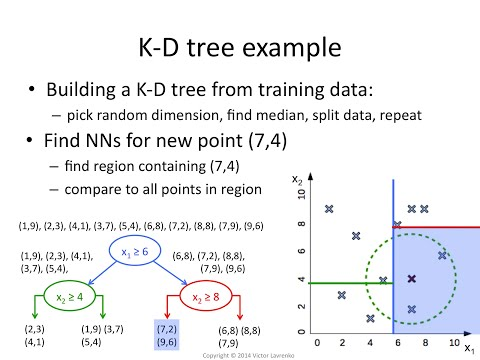

In [226]:
from IPython.display import YouTubeVideo
YouTubeVideo('Y4ZgLlDfKDg')

In [227]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

# <font color="#E56717">Finding the distance to all of the 4 nearest neighbors only took about 40 minutes</font>

In [228]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [229]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

dist1filter = (dftreeleague['distance_1'] <= 2)
dist2filter = (dftreeleague['distance_2'] <= 2)
dist3filter = (dftreeleague['distance_3'] <= 2)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
patient_id,,,
8865019342,8882020381,0.630215,0
4315229060,8792067479,1.547750,0
4473112043,4408106073,0.564975,0
8851092441,8841081424,1.830495,0
8870085471,8835013250,1.688191,0
8889005430,8848090384,1.045589,0
0242402011,4296067064,1.368016,0
0244410011,4208088055,1.010414,0
0247485010,0209461001,1.928086,0


In [230]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict, threedict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodtreatmentteams = list(dd.keys())

goodcontrolteams = list(dd.values())
matches = list(set([item for sublist in goodcontrolteams for item in sublist]))

controlindices = matches
treatmentindices = goodtreatmentteams
print(len(treatmentindices))
print(len(controlindices))

973
2244


# <font color="#E56717">Need to do a one-to-one matching (where each member of the treatment group is matched to one and only one member of the control group, and where that matched control corresopnds to only one member of the treatment group</font>

In [231]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_t_c = {}

for key, value in d_one_to_one.items():
    if value not in d_t_c.values():
        d_t_c[key] = value
        
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())    

In [232]:
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())

print(len(controlindices), len(treatmentindices))

916 916


<span style="font-size:1.8em;">So we have 916 treatment patients matched very closely to 916 control patients</span>

In [233]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srvm1"]
Econtrol = resgoodpop.loc[controlindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[treatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='No PBT Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='PBT Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");

<lifelines.KaplanMeierFitter: fitted with 916 observations, 835 censored>

# <font color="#E56717">Now here is the Kaplan-Meier plot of the post-matching treatment and control groups</font>

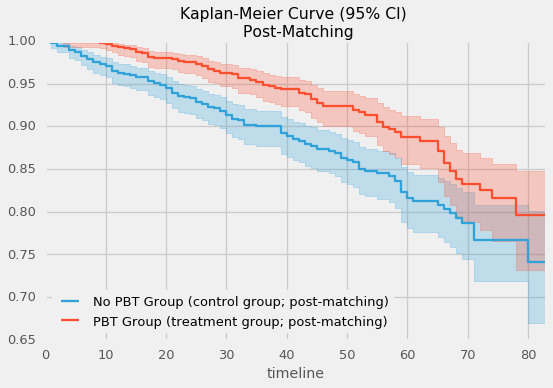

In [234]:
mpld3.enable_notebook()
ax = kmfcontrolpost.plot(figsize=(8,5))
kmftreatmentpost.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Post-Matching");

# <font color="#E56717">We can perform a rigorous test to see if the two survival curves truly have different DGPs (data generation processes)</font>

In [235]:
from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()


Results
   t 0: -1
   null distribution: chi squared
   df: 1
   test: logrank
   alpha: 0.95

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00033 |             12.886 |      Reject Null    |        True       


In [236]:
import pickle
fileObject = open('control_indicies.pickle','wb')
pickle.dump(controlindices, fileObject)
fileObject.close()

In [237]:
import pickle
fileObject = open('treatment_indicies.pickle','wb')
pickle.dump(treatmentindices, fileObject)
fileObject.close()

In [238]:
df = df.set_index('patient_id',drop=False)

# <font color="#E56717">Investigate the results of the matching</font>

# <font color="#E56717">Gender breakdown</font>

In [239]:
df['m_sex'][df['patient_id'].isin(treatmentindices)].value_counts()

Male      889
Female     27
Name: m_sex, dtype: int64

In [240]:
df['m_sex'][df['patient_id'].isin(controlindices)].value_counts()

Male      889
Female     27
Name: m_sex, dtype: int64

# <font color="#E56717">Marital status breakdown</font>

In [241]:
df['marst1'][df['patient_id'].isin(treatmentindices)].value_counts()

Married (including common law)    722
Divorced                           57
Single (never married)             52
Unknown                            42
Widowed                            38
Separated                           5
Name: marst1, dtype: int64

In [242]:
df['marst1'][df['patient_id'].isin(controlindices)].value_counts()

Married (including common law)    722
Divorced                           57
Single (never married)             52
Unknown                            42
Widowed                            38
Separated                           5
Name: marst1, dtype: int64

# <font color="#E56717">Racial breakdown</font>

In [243]:
df['srace'][df['patient_id'].isin(treatmentindices)].value_counts()

White                                                                                                                 840
Black                                                                                                                  41
Chinese                                                                                                                 9
Other Asian, including Asian, NOS and Oriental NOS                                                                      8
Filipino                                                                                                                7
Korean                                                                                                                  5
Japanese                                                                                                                5
American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)      1
Name: srace, dtype: int6

In [244]:
df['srace'][df['patient_id'].isin(controlindices)].value_counts()


White                                                                                                                 840
Black                                                                                                                  41
Chinese                                                                                                                 9
Other Asian, including Asian, NOS and Oriental NOS                                                                      8
Filipino                                                                                                                7
Korean                                                                                                                  5
Japanese                                                                                                                5
American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)      1
Name: srace, dtype: int6

# <font color="#E56717">nhiade breakdown</font>

In [245]:
df['nhiade'][df['patient_id'].isin(treatmentindices)].value_counts()

Non-Spanish-Hispanic-Latino                   866
Spanish/Hispanic/Latino, NOS                   30
Mexican                                         9
NHIA Surname Match Only                         7
South or Central American excluding Brazil      3
Cuban                                           1
Name: nhiade, dtype: int64

In [246]:

df['nhiade'][df['patient_id'].isin(controlindices)].value_counts()

Non-Spanish-Hispanic-Latino                   866
Spanish/Hispanic/Latino, NOS                   30
Mexican                                         9
NHIA Surname Match Only                         7
South or Central American excluding Brazil      3
Cuban                                           1
Name: nhiade, dtype: int64

# <font color="#E56717">Grade breakdown</font>

In [247]:
df['grade1'][df['patient_id'].isin(treatmentindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               481
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    388
cell type not determined, not stated or not applicable                                                              40
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  4
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            3
Name: grade1, dtype: int64

In [248]:
df['grade1'][df['patient_id'].isin(controlindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               481
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    388
cell type not determined, not stated or not applicable                                                              40
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  4
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            3
Name: grade1, dtype: int64

# <font color="#E56717">Site breakdown</font>

In [249]:
df['site1'][df['patient_id'].isin(treatmentindices)].value_counts()

Prostate gland                    857
Upper lobe, lung                   22
Choroid                            18
Lower lobe, lung                    5
Upper-outer quadrant of breast      3
Lower-inner quadrant of breast      2
Lower third of esophagus            2
Overlapping lesion of breast        2
Frontal lobe                        1
Parietal lobe                       1
Parotid gland                       1
Temporal lobe                       1
Lung, NOS                           1
Name: site1, dtype: int64

In [250]:
df['site1'][df['patient_id'].isin(controlindices)].value_counts()

Prostate gland                    857
Upper lobe, lung                   22
Choroid                            18
Lower lobe, lung                    5
Upper-outer quadrant of breast      3
Lower-inner quadrant of breast      2
Lower third of esophagus            2
Overlapping lesion of breast        2
Frontal lobe                        1
Parietal lobe                       1
Parotid gland                       1
Temporal lobe                       1
Lung, NOS                           1
Name: site1, dtype: int64

# <font color="#E56717">Histology breakdown</font>

In [251]:
df['histrec1'][df['patient_id'].isin(treatmentindices)].value_counts()


8140-8398: adenomas and adenocarcinomas    867
8720-8799: nevi and melanomas               18
8010-8049: epithelial neplasms, NOS         10
8050-8089: squamous cell neplasms            9
8500-8549: ductal and lobular neoplasms      7
9380-9489: gliomas                           3
8560-8579: complex epithelial neoplasms      1
8550-8559: acinar cell neoplasms             1
Name: histrec1, dtype: int64

In [252]:
df['histrec1'][df['patient_id'].isin(controlindices)].value_counts()

8140-8398: adenomas and adenocarcinomas    867
8720-8799: nevi and melanomas               18
8010-8049: epithelial neplasms, NOS         10
8050-8089: squamous cell neplasms            9
8500-8549: ductal and lobular neoplasms      7
9380-9489: gliomas                           3
8560-8579: complex epithelial neoplasms      1
8550-8559: acinar cell neoplasms             1
Name: histrec1, dtype: int64

# <font color="#E56717">Month of diagnosis breakdown</font>

In [253]:
df['modx1'][df['patient_id'].isin(treatmentindices)].value_counts()

Mar    85
Jun    84
Aug    84
Feb    83
Jul    81
Jan    79
May    77
Oct    76
Nov    73
Apr    72
Sep    66
Dec    53
Name: modx1, dtype: int64

In [254]:
df['modx1'][df['patient_id'].isin(controlindices)].value_counts()

Mar    85
Jun    84
Aug    84
Feb    83
Jul    81
Jan    79
May    77
Oct    76
Nov    73
Apr    72
Sep    66
Dec    53
Name: modx1, dtype: int64

# <font color="#E56717">birthyr breakdown</font>

In [255]:

df['birthyr'][df['patient_id'].isin(treatmentindices)].describe()

count     916.000000
mean     1937.013100
std         5.637098
min      1918.000000
25%      1934.000000
50%      1938.000000
75%      1941.000000
max      1957.000000
Name: birthyr, dtype: float64

In [256]:
df['birthyr'][df['patient_id'].isin(controlindices)].describe()

count     916.000000
mean     1936.842795
std         5.267839
min      1920.000000
25%      1933.000000
50%      1937.000000
75%      1941.000000
max      1953.000000
Name: birthyr, dtype: float64

# <font color="#E56717">Age at diagnosis breakdown</font>

In [257]:
df['agedx1'][df['patient_id'].isin(treatmentindices)].describe()

count    916.000000
mean      70.958515
std        5.384294
min       53.000000
25%       67.000000
50%       70.000000
75%       74.000000
max       89.000000
Name: agedx1, dtype: float64

In [258]:
df['agedx1'][df['patient_id'].isin(controlindices)].describe()

count    916.000000
mean      71.018559
std        5.036987
min       55.000000
25%       67.000000
50%       70.000000
75%       74.000000
max       88.000000
Name: agedx1, dtype: float64

# <font color="#E56717">Laterality breakdown</font>

In [259]:
df['lat1'][df['patient_id'].isin(treatmentindices)].value_counts()

Not a paired site                                                       859
Right: origin of primary                                                 32
Left: origin of primary                                                  24
Paired site, but no information concerning laterality; midline tumor      1
Name: lat1, dtype: int64

In [260]:
df['lat1'][df['patient_id'].isin(controlindices)].value_counts()

Not a paired site                                                       859
Right: origin of primary                                                 32
Left: origin of primary                                                  24
Paired site, but no information concerning laterality; midline tumor      1
Name: lat1, dtype: int64

# <font color="#E56717">latitude breakdown</font>

In [261]:
df['lat_1'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count    916.000000
mean      35.867029
std        3.119296
min       21.306986
25%       33.953297
50%       34.959208
75%       38.029655
max       48.611804
Name: lat_1, dtype: float64

In [262]:
df['lat_1'][df['patient_id'].isin(controlindices)].astype('float').describe()

count    916.000000
mean      36.053560
std        3.124011
min       21.306986
25%       33.953297
50%       34.959208
75%       37.853409
max       48.611804
Name: lat_1, dtype: float64

# <font color="#E56717">Longitude breakdown</font>

In [263]:
df['lng_1'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count    916.000000
mean    -113.258361
std       13.697243
min     -157.858432
25%     -119.698206
50%     -117.396119
75%     -116.419389
max      -72.046816
Name: lng_1, dtype: float64

In [264]:

df['lng_1'][df['patient_id'].isin(controlindices)].astype('float').describe()

count    916.000000
mean    -113.038286
std       14.048292
min     -157.858432
25%     -120.987632
50%     -118.243660
75%     -116.419389
max      -72.046816
Name: lng_1, dtype: float64

# <font color="#E56717">Elevation breakdown</font>

In [265]:

df['elevation'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count      916.000000
mean      1215.051855
std       1474.981068
min       -199.678057
25%        115.495536
50%        827.483657
75%       1561.999233
max      10069.186315
Name: elevation, dtype: float64

In [266]:
df['elevation'][df['patient_id'].isin(controlindices)].astype('float').describe()

count      916.000000
mean      1131.699613
std       1462.893440
min       -199.678057
25%        150.117353
50%        713.249840
75%       1419.385520
max      10616.362503
Name: elevation, dtype: float64

# <font color="#E56717">Are PBT or conventional RT patients more likely to eperience secondary malignancies?</font>

In [267]:

print(df['agedx2'].loc[controlindices].value_counts().sum(), df['agedx2'].loc[controlindices].shape)

65 (916,)


In [268]:
print(df['agedx2'].loc[treatmentindices].value_counts().sum(), df['agedx2'].loc[treatmentindices].shape)

46 (916,)


# <font color="#E56717">So 65 out of 916 control patients had a second primary tumor, while 47 out of 916 PBT patients had a second primary tumor.</font>

In [269]:
df['modx1'].head()


patient_id
0205455031    Jun
0208413011    Dec
0208497001    Nov
0212443031    Sep
0212448031    Aug
Name: modx1, dtype: object

In [270]:

monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}

In [271]:
df['month1'] = df['modx1'].replace(monthdict)

In [272]:
df['modx2'] = df['modx2'].replace(monthdict)

In [273]:
df['datedx1'] = df.yrdx1.astype('str') + df.month1.astype('str')

df['datedx1'] = pd.to_datetime(df['datedx1'][df['month1'].notnull()], 
                                                      format='%Y%m')

In [274]:
df['datedx2'] = df.yrdx2.astype('str').str.replace('\.0','') + df.modx2.astype('str')

In [275]:
df['datedx2'] = pd.to_datetime(df['datedx2'][~df['datedx2'].str.contains('nan',case=False,na=False)], 
                                                     format='%Y%m')

In [276]:
dffollowupcontrol = df[['datedx1','datedx2','srvm1']].loc[controlindices].copy()

dffollowuptreatment = df[['datedx1','datedx2','srvm1']].loc[treatmentindices].copy()

In [277]:
df[['datedx1','datedx2','srvm1']].loc[controlindices].head()

,datedx1,datedx2,srvm1
patient_id,,,
4492175004,2010-02-01,NaT,30
8805036443,2011-05-01,NaT,19
8828042441,2010-12-01,NaT,24
8862022355,2009-06-01,NaT,42
8879060343,2008-05-01,NaT,55


In [278]:
def make_months(i):
    if i.value != -9223372036854775808:
        return i.days/30
    else:
        return i

In [279]:
dffollowupcontrol['delta'] = pd.to_timedelta(dffollowupcontrol['datedx2'] - dffollowupcontrol['datedx1'],unit='m')

dffollowuptreatment['delta'] = pd.to_timedelta(dffollowuptreatment['datedx2'] - dffollowuptreatment['datedx1'],unit='m')


dffollowupcontrol['delta_months'] = dffollowupcontrol.delta.apply(make_months)

dffollowuptreatment['delta_months'] = dffollowuptreatment.delta.apply(make_months).astype('object')

In [280]:
from dateutil import relativedelta

In [281]:
dffollowupcontrol.head()

,datedx1,datedx2,srvm1,delta,delta_months
patient_id,,,,,
4492175004,2010-02-01,NaT,30,NaT,NaT
8805036443,2011-05-01,NaT,19,NaT,NaT
8828042441,2010-12-01,NaT,24,NaT,NaT
8862022355,2009-06-01,NaT,42,NaT,NaT
8879060343,2008-05-01,NaT,55,NaT,NaT


In [282]:
dffollowupcontrol['followup_months'] = dffollowupcontrol['delta_months'].fillna(dffollowupcontrol.srvm1)

In [283]:
dffollowupcontrol.head()

,datedx1,datedx2,srvm1,delta,delta_months,followup_months
patient_id,,,,,,
4492175004,2010-02-01,NaT,30,NaT,NaT,1970-01-01 00:00:00.000000030
8805036443,2011-05-01,NaT,19,NaT,NaT,1970-01-01 00:00:00.000000019
8828042441,2010-12-01,NaT,24,NaT,NaT,1970-01-01 00:00:00.000000024
8862022355,2009-06-01,NaT,42,NaT,NaT,1970-01-01 00:00:00.000000042
8879060343,2008-05-01,NaT,55,NaT,NaT,1970-01-01 00:00:00.000000055


In [284]:
dffollowuptreatment['followup_months'] = dffollowuptreatment['delta_months'].fillna(dffollowuptreatment.srvm1)

In [285]:

def make_months_treatment(i):
    try:
        return int(i.days/30)
    except:
        return i

In [286]:
dffollowuptreatment.head()

,datedx1,datedx2,srvm1,delta,delta_months,followup_months
patient_id,,,,,,
4468177055,2011-02-01,NaT,22,NaT,NaT,22
8866096432,2011-05-01,NaT,19,NaT,NaT,19
8805039402,2010-12-01,NaT,24,NaT,NaT,24
8846080335,2009-06-01,2012-01-01,42,944 days,1970-01-01 00:00:00.000000031,1970-01-01 00:00:00.000000031
8860058333,2008-05-01,NaT,55,NaT,NaT,55


In [287]:
delta_months = dffollowuptreatment[dffollowuptreatment.delta.notnull()].delta.apply(make_months_treatment)
dffollowuptreatment['delta_months'] = delta_months
dffollowuptreatment['followup_months'] = dffollowuptreatment['delta_months'].fillna(dffollowuptreatment.srvm1)
dffollowuptreatment[dffollowuptreatment.delta.notnull()]

,datedx1,datedx2,srvm1,delta,delta_months,followup_months
patient_id,,,,,,
8846080335,2009-06-01,2012-01-01,42,944 days,31.0,31.0
8892082319,2009-10-01,2012-03-01,38,882 days,29.0,29.0
8862001325,2009-06-01,2010-10-01,29,487 days,16.0,16.0
8801042393,2008-03-01,2008-04-01,57,31 days,1.0,1.0
8880017354,2009-02-01,2010-11-01,46,638 days,21.0,21.0
8837091492,2011-04-01,2011-12-01,20,244 days,8.0,8.0
4436175014,2009-05-01,2010-08-01,31,457 days,15.0,15.0
8812011384,2008-07-01,2010-08-01,53,761 days,25.0,25.0
8810023332,2007-03-01,2009-03-01,68,731 days,24.0,24.0


In [288]:
delta_months = dffollowupcontrol[dffollowupcontrol.delta.notnull()].delta.apply(make_months_treatment)
dffollowupcontrol['delta_months'] = delta_months
dffollowupcontrol['followup_months'] = dffollowupcontrol['delta_months'].fillna(dffollowupcontrol.srvm1)
dffollowupcontrol[dffollowupcontrol.delta.notnull()]

,datedx1,datedx2,srvm1,delta,delta_months,followup_months
patient_id,,,,,,
2655038072,2007-04-01,2008-11-01,43,580 days,19.0,19.0
8824022384,2008-12-01,2010-11-01,48,700 days,23.0,23.0
8826020441,2010-03-01,2012-11-01,33,976 days,32.0,32.0
2618018013,2010-10-01,2011-07-01,17,273 days,9.0,9.0
8879010303,2008-03-01,2009-01-01,20,306 days,10.0,10.0
8816062363,2007-10-01,2009-08-01,24,670 days,22.0,22.0
8854017392,2007-01-01,2010-02-01,52,1127 days,37.0,37.0
8834098351,2006-09-01,2010-05-01,75,1338 days,44.0,44.0
4463107085,2011-09-01,2012-01-01,15,122 days,4.0,4.0


In [289]:
dffollowuptreatment.followup_months.mean()

43.76091703056768

In [290]:
dffollowupcontrol.followup_months.mean()

42.69213973799127

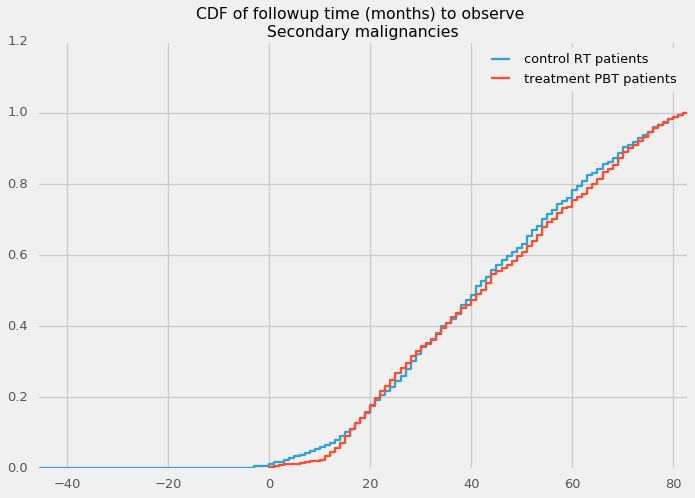

In [291]:
ax = dffollowupcontrol.followup_months.value_counts(normalize=True).sort_index().cumsum().plot(label='control RT patients',
                                                                            drawstyle='steps')
dffollowuptreatment.followup_months.value_counts(normalize=True).sort_index().cumsum().plot(drawstyle='steps',
                                                                                          ax=ax,
                                                                            label='treatment PBT patients')

plt.title("CDF of followup time (months) to observe \nSecondary malignancies");
plt.legend()

In [292]:
print(df['agedx2'].loc[controlindices].value_counts().sum(), df['agedx2'].loc[controlindices].shape)

65 (916,)


In [293]:
print(df['agedx2'].loc[treatmentindices].value_counts().sum(), df['agedx2'].loc[treatmentindices].shape)

46 (916,)


# <font color="#E56717">Assess the statistical significance of this difference with Bayesian A/B testing</font>

In [294]:
probcontrol = 65/916
probtreatment = 47/916
print(probcontrol,probtreatment)

0.07096069868995633 0.05131004366812227


In [295]:
controltotal = 916
treatmenttotal = 916
controlsecondary = 65
treatmentsecondary = 47

In [296]:
TREATMENT_SECONDARY = treatmentsecondary
CONTROL_SECONDARY = controlsecondary
TREATMENT_TOTAL = treatmenttotal
CONTROL_TOTAL = controltotal
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1
posterior_treatment = beta(alpha_prior + TREATMENT_SECONDARY, beta_prior + TREATMENT_TOTAL - TREATMENT_SECONDARY)
posterior_control = beta(alpha_prior + CONTROL_SECONDARY, beta_prior + CONTROL_TOTAL - CONTROL_SECONDARY)
samples = 2000000
samples_posterior_treatment = posterior_treatment.rvs(samples)
samples_posterior_control = posterior_control.rvs(samples)
(samples_posterior_control > samples_posterior_treatment).mean()

0.9599145

In [297]:
mpld3.disable_notebook();

(0, 0.2)

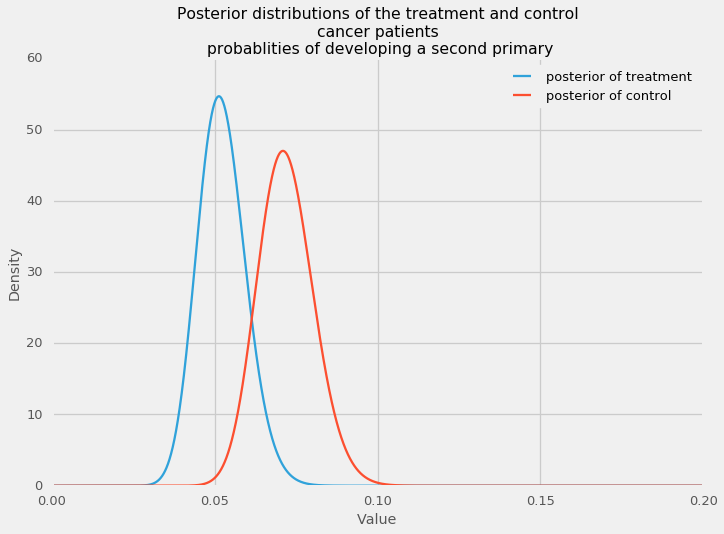

In [298]:
x = np.linspace(0,1, 50000)
plt.plot(x, posterior_treatment.pdf(x), label='posterior of treatment')
plt.plot(x, posterior_control.pdf(x), label='posterior of control');
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("""Posterior distributions of the treatment and control
cancer patients\n probablities of developing a second primary""")
plt.legend();
plt.xlim(0,.2)

# <font color="#E56717">Look at some matched pairs</font>

In [299]:
goodcols_eval = ['m_sex','marst1','srace','nhiade','grade1','site1','lat1','lat_1','lng_1',
                 'elevation_1','histrec1',
            'modx1','birthyr','agedx1','yrdx1']

In [300]:
df[goodcols_eval].loc[[controlindices[0],treatmentindices[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4492175004,Male,Unknown,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,39.9653,-74.3118,58.8656,8140-8398: adenomas and adenocarcinomas,Feb,1937,72,2010
4468177055,Male,Unknown,White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Prostate gland,Not a paired site,39.1059,-74.8273,11.4805,8140-8398: adenomas and adenocarcinomas,Feb,1935,75,2011


In [301]:
choroidindex = list(df[goodcols_eval][df.site1.str.contains('choroid',case=False,na=False)].index)

treatmentchoroid = [a for a in set(choroidindex).intersection(set(treatmentindices))]


#####################################################################################################

lungindex = list(df[goodcols_eval][df.site1.str.contains('lung',case=False,na=False)].index)

treatmentlung = [a for a in set(lungindex).intersection(set(treatmentindices))]

############################################################################################################


cerebralindex = list(df[goodcols_eval][df.site1.str.contains('cerebral',case=False,na=False)].index)

treatmentcerebral = [a for a in set(cerebralindex).intersection(set(treatmentindices))]

##############################################################################################################

esophagusindex = list(df[goodcols_eval][df.site1.str.contains('esophagus',case=False,na=False)].index)

treatmentesophagus = [a for a in set(esophagusindex).intersection(set(treatmentindices))]

#####################################################################################################################


breastindex = list(df[goodcols_eval][df.site1.str.contains('breast',case=False,na=False)].index)

treatmentbreast = [a for a in set(breastindex).intersection(set(treatmentindices))]

In [302]:
df[goodcols_eval].loc[[d_t_c[treatmentchoroid[0]],treatmentchoroid[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
0209461001,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Right: origin of primary,41.3267,-72.8043,115.879,8720-8799: nevi and melanomas,Jul,1926,83,2009
0247485010,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Right: origin of primary,41.7924,-72.8043,784.126,8720-8799: nevi and melanomas,Jul,1918,87,2006


In [303]:
df[goodcols_eval].loc[[d_t_c[treatmentlung[0]],treatmentlung[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4482160083,Male,Married (including common law),Black,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...","Upper lobe, lung",Right: origin of primary,39.7103,-75.1078,150.117,8050-8089: squamous cell neplasms,Mar,1935,72,2008
4462162024,Male,Married (including common law),Black,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...","Upper lobe, lung",Right: origin of primary,39.8592,-75.0144,49.2433,8050-8089: squamous cell neplasms,Mar,1936,73,2009


In [304]:
df[goodcols_eval].loc[[d_t_c[treatmentesophagus[0]],treatmentesophagus[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4408106073,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Lower third of esophagus,Not a paired site,39.9653,-74.3118,58.8656,8140-8398: adenomas and adenocarcinomas,Dec,1929,77,2006
4473112043,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Lower third of esophagus,Not a paired site,39.8592,-75.0144,49.2433,8140-8398: adenomas and adenocarcinomas,Dec,1928,79,2007


In [305]:
df[goodcols_eval].loc[[d_t_c[treatmentbreast[0]],treatmentbreast[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8785033458,Female,Single (never married),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Lower-inner quadrant of breast,Right: origin of primary,31.5282,-83.8897,399.093,8500-8549: ductal and lobular neoplasms,Feb,1942,63,2006
8771011409,Female,Single (never married),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Lower-inner quadrant of breast,Right: origin of primary,33.7956,-84.2279,919.933,8500-8549: ductal and lobular neoplasms,Feb,1939,69,2009


In [306]:
dgt = df[goodcols_eval].loc[treatmentindices].copy()
dgc = df[goodcols_eval].loc[controlindices].copy()
from mpl_toolkits.basemap import Basemap

In [307]:
centers_dict = {'Davis, CA': [38.5568118,-121.7700491],
               'Loma Linda, CA': [34.0428589,-117.2838294],
               'Boston, MA': [42.3132878,-71.1975851],
               'Seattle, WA': [47.6147624,-122.4763332],
               'Bloomington, IN': [39.1711919,-86.602058],
               'Jacksonville, FL': [30.3446899,-82.0013407],
               'Houston, TX': [29.8168809,-95.6821725],
               'Oklahoma City, OK': [35.4823226,-97.7600756],
               'Warrenvlile, IL': [41.8247102,-88.2168148],
               'Philadelphia, PA': [40.004668,-75.2584614],
               'Hampton, VA': [37.0403431,-76.4311508],
               'Somerset, NJ': [40.5012296,-74.507752],
               'St. Louis, MO': [38.6530166,-90.3838907],
               'Knoxville, TN': [35.9583816,-84.0655115],
               'San Diego, CA': [32.8242389,-117.3760429],
               'Jacksonville, FL': [30.3446899,-82.0013407],
               'New Brunswick, NJ': [40.4882392,-74.4763898],
               'Dallas Fort Worth, TX': [32.7724978,-97.2485344],
               'Phoenix, AZ': [33.6050976,-112.4059302],
               'Rochester, MN': [43.9959015,-92.6216003],
               'Orlando, FL': [28.4810968,-81.5091799],
               'Miami, FL': [25.7823071,-80.3012157]}

In [308]:
center_lats = [l[0] for l in centers_dict.values()]
center_lngs = [l[1] for l in centers_dict.values()]

# <font color="#E56717">It is informative to plot hte locations of the treatment and control patients on a map, along with the location of the PBT centers</font>

* <span style="font-size:1.5em;">Knoxville, TN; Warrenville, IL; Philadelphia, PA; Seattle, WA</span>
* <span style="font-size:1.5em;">Loma Linda, CA; San Diego, CA; Oralando, FL; Bloomington, IN (now closed)</span>
* <span style="font-size:1.5em;">Rochester, MN; New Brunswick, NJ; Houston, TX; St. Louis, MO</span>
* <span style="font-size:1.5em;">Miami, FL; Davis, CA; Dallas Fort-Worth, TX; Boston, MA</span>
* <span style="font-size:1.5em;">Somerset, NJ; Oklahoma City, OK; Jacksonville, FL; Phoenix, AZ</span>
* <span style="font-size:1.5em;">Hampton, VA</span>

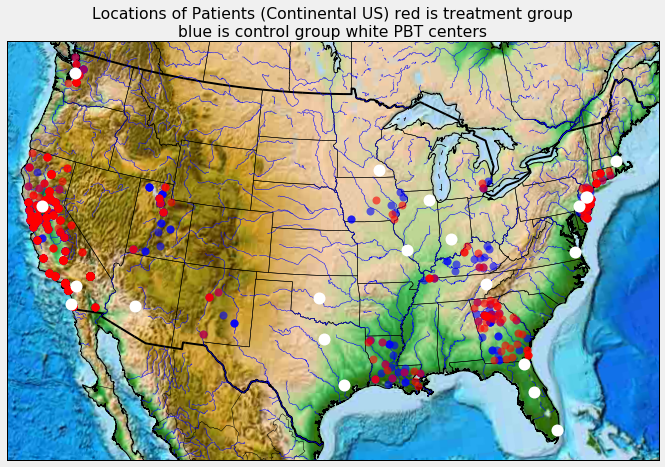

In [309]:
# Lambert Conformal map of USA lower 48 states
mpld3.disable_notebook()
m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
  urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
  lon_0=-95, resolution='h', area_thresh=10000)

m.drawcoastlines()
# draw country boundaries
m.drawcountries(linewidth=2)
# draw states boundaries (America only)
m.drawstates()
#m.bluemarble()
m.etopo()

# fill the background (the oceans)
m.drawmapboundary(fill_color='aqua')
# fill the continental area
# we color the lakes like the oceans
#m.fillcontinents(color='coral',lake_color='aqua')

m.drawrivers(color='#0000ff')

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
x,y = m(dgt['lng_1'].values, dgt['lat_1'].values)
xc, yc = m(dgc['lng_1'].values, dgc['lat_1'].values)
xcenters, ycenters = m(center_lngs, center_lats)

# Plot them using round markers of size 6
#m.plot(x, y, 'ro', markersize=8,alpha=.7)
m.plot(xc,yc, 'bo', markersize=8,alpha=.6)
m.plot(x, y, 'ro', markersize=8,alpha=.6)
m.plot(xcenters, ycenters, 'wo', markersize=12)

plt.title("Locations of Patients (Continental US) red is treatment group\nblue is control group white "+\
         "PBT centers")

plt.savefig('map_with_centers.png', format='png')
plt.show()

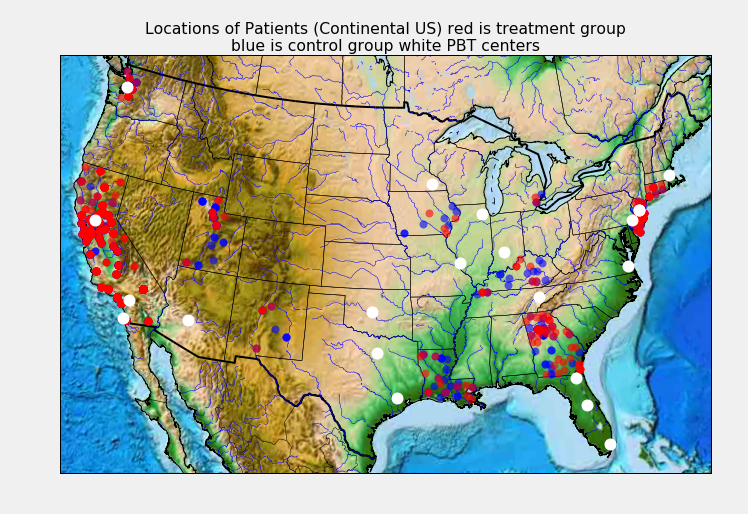

In [310]:
## This is for an `png` image
from IPython.display import Image

fig = Image(filename=('map_with_centers.png'),embed=True)
fig


# <font color="#E56717">Are PBT or conventional RT patients more likely to experience secondary malignancies?</font>

<span style="font-size:1.5em;">We can explore this question in two ways.</span>

In [311]:
print(df['agedx2'].loc[controlindices].value_counts().sum(), df['agedx2'].loc[controlindices].shape)

65 (916,)


In [312]:
print(df['agedx2'].loc[treatmentindices].value_counts().sum(), df['agedx2'].loc[treatmentindices].shape)

46 (916,)


In [313]:
control_agedx2 = df['agedx2'].loc[controlindices].notnull().astype('int')
treatment_agedx2 = df['agedx2'].loc[treatmentindices].notnull().astype('int')
dfagedx2_comp = pd.DataFrame({'control_id': control_agedx2.index,
                             'control_agedx2': control_agedx2.values,
                             'treatment_id': treatment_agedx2.index,
                             'treatment_agedx2': treatment_agedx2.values})

# 1 indicates you have a secondary malignancy

In [314]:
from scipy.stats import ttest_ind

t, p = ttest_ind(dfagedx2_comp.control_agedx2.as_matrix(),
               dfagedx2_comp.treatment_agedx2.as_matrix())

print(t,p)


1.86139251213 0.062848997454


In [315]:
from scipy.stats import ranksums, ttest_rel

ttest_rel(dfagedx2_comp.control_agedx2.as_matrix(),
               dfagedx2_comp.treatment_agedx2.as_matrix())



Ttest_relResult(statistic=1.8932357482347542, pvalue=0.058641828215614179)

In [316]:
from scipy.stats import ranksums, wilcoxon

t, p = wilcoxon(dfagedx2_comp.control_agedx2.as_matrix(),
               dfagedx2_comp.treatment_agedx2.as_matrix())

print(t,p)

2091.0 0.0586816797282


In [317]:
smallcontrolindices.shape

(131038,)

In [318]:
smalltreatmentindices.shape

(1200,)

In [319]:
dfalltreatment.shape, dfallcontrol.shape

((1200, 496), (131038, 496))

In [320]:
dftree

,m_sex_Female,marst1_Divorced,marst1_Married (including common law),marst1_Separated,marst1_Single (never married),marst1_Unknown,marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered),marst1_Widowed,"srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",srace_Asian Indian,...,modx1_May,modx1_Nov,modx1_Oct,modx1_Sep,birthyr,agedx1,yrdx1,lat_1,lng_1,elevation_1
patient_id,,,,,,,,,,,,,,,,,,,,,
0232466001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1937,73.0,2011,41.786629,-73.276536,1066.803253
0237405040,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1924,82.0,2006,41.326691,-72.804280,115.878780
0239435040,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1944,62.0,2006,41.469851,-72.473153,11.187957
0242412040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1950,56.0,2007,41.469851,-72.473153,11.187957
0242468070,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1926,80.0,2007,41.326691,-72.804280,115.878780
0243456001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1929,82.0,2011,41.792434,-72.804280,784.126417
0246429020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1926,80.0,2007,41.255965,-73.370870,471.480778
0246458060,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1930,77.0,2007,41.326691,-72.804280,115.878780
0253402080,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1940,67.0,2007,41.792434,-72.804280,784.126417


In [321]:
resgreatpop['patient_id'] = resgreatpop.index
leaguefilter = (resgreatpop['patient_id'].loc[smalltreatmentindices])
resgreatpop['League'] = resgreatpop['patient_id'].isin(smalltreatmentindices).astype('int')
del resgreatpop['patient_id']
dftree = resgreatpop.copy()

In [322]:
y = dftree['League'].copy()

In [323]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy

y_train = dftree['League'].copy()
yTrain = numpy.array(y_train)

x_train = dftree[dftree.columns[:-1]]
xTrain = x_train.values

featurenames = x_train.columns

print(yTrain)

[0 0 0 ..., 1 1 1]


In [324]:
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

clf_dt = tree.DecisionTreeClassifier(criterion='entropy',
                                     max_depth=30, min_samples_leaf=3)

In [325]:

clf_dt.fit(xTrain, yTrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=30,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [326]:
def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred = clf.predict(X)
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)), "\n")
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred), "\n")
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y, y_pred), "\n")

In [327]:

measure_performance(xTrain, yTrain, clf_dt)

Accuracy:0.994 

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    131038
          1       0.79      0.50      0.61      1200

avg / total       0.99      0.99      0.99    132238
 

Confusion matrix
[[130879    159]
 [   600    600]] 



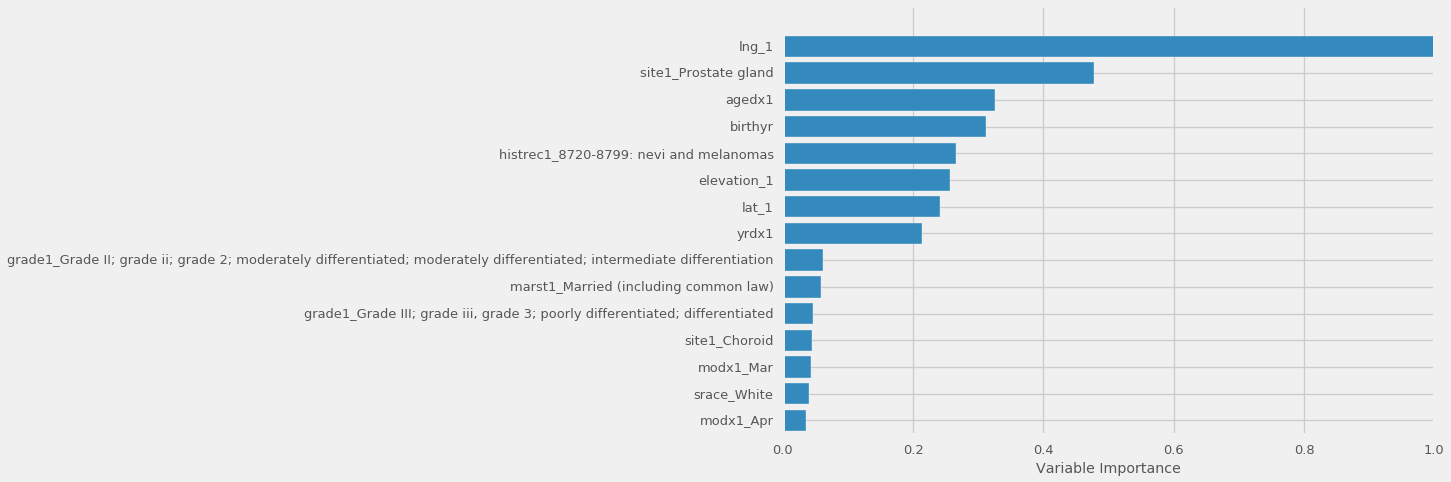

In [328]:
# Plot feature importance
featureImportance = clf_dt.feature_importances_

# normalize by max importance
featureImportance = featureImportance / featureImportance.max()

#plot variable importance
idxSorted = numpy.argsort(featureImportance)[-15:]
barPos = numpy.arange(idxSorted.shape[0]) + .5
plot.barh(barPos, featureImportance[idxSorted], align='center')
plot.yticks(barPos, featurenames[idxSorted])
plot.xlabel('Variable Importance')
plot.show()

In [329]:
from sklearn.ensemble import RandomForestClassifier

In [330]:
rf = RandomForestClassifier(n_estimators=200,min_samples_split=3,
                             max_depth = 45,
                            max_features = .8,
                             n_jobs=5,verbose=2,random_state=3)

In [331]:
rf = rf.fit(xTrain, yTrain)

building tree 1 of 200building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200

building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    7.9s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   37.3s


building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:   48.5s finished


In [332]:
measure_performance(xTrain, yTrain, rf)

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    6.6s finished


Accuracy:0.999 

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    131038
          1       1.00      0.88      0.93      1200

avg / total       1.00      1.00      1.00    132238
 

Confusion matrix
[[131033      5]
 [   149   1051]] 



In [333]:
aucCalc = roc_auc_score(yTrain, rf.predict_proba(xTrain)[:,1:2])

print("AUC: ", aucCalc)

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


AUC:  0.999984072686


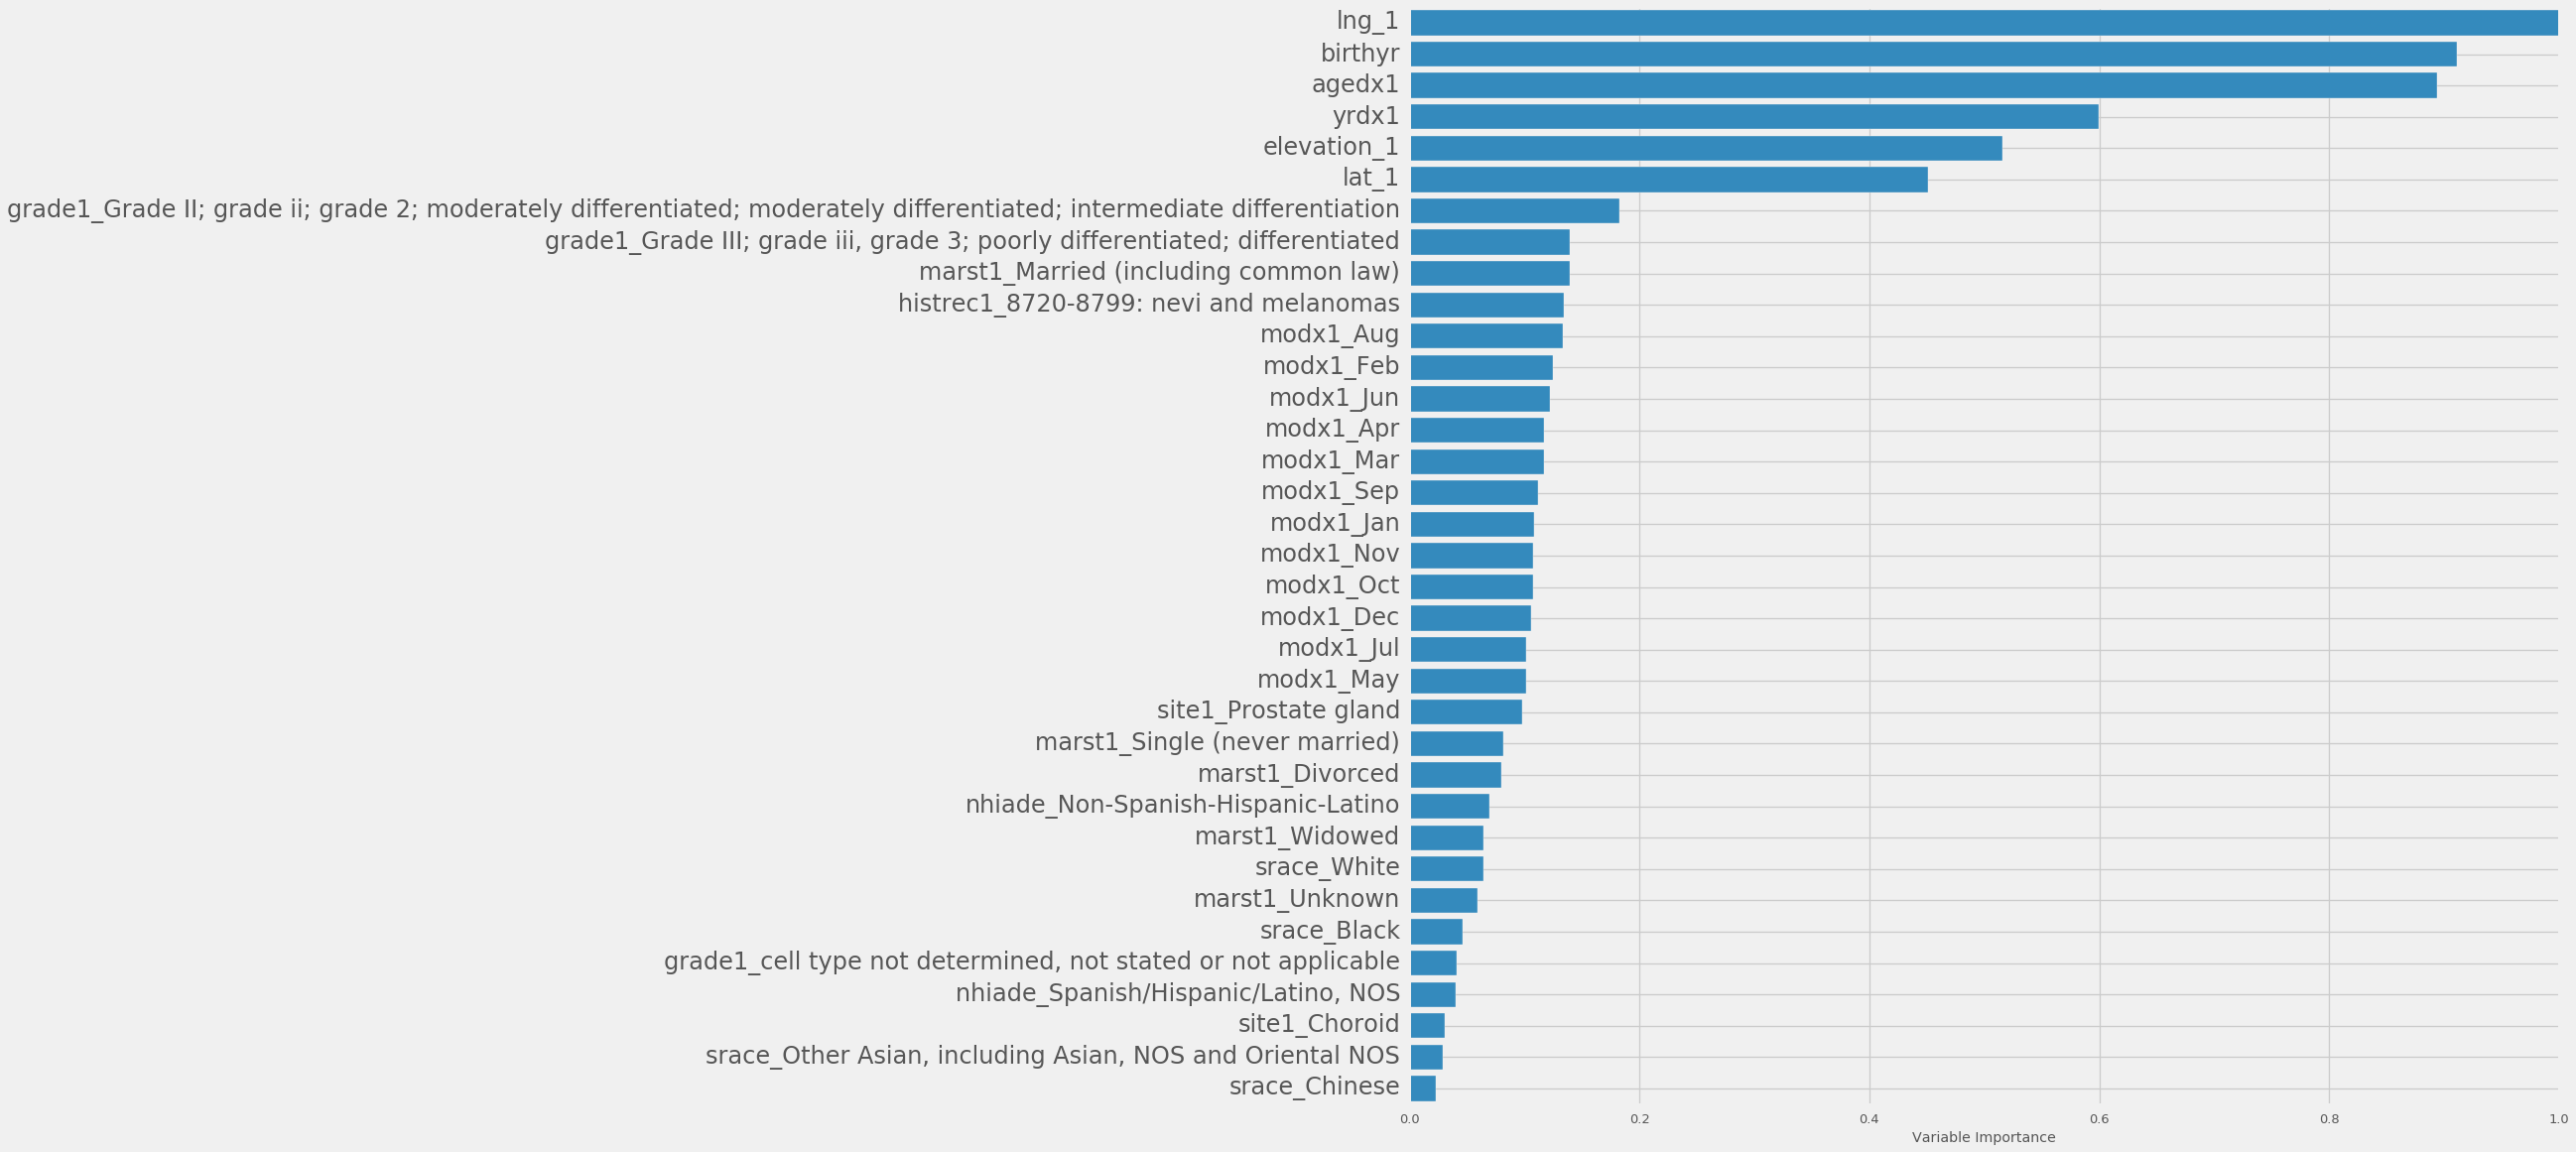

In [334]:
# Plot feature importance
featureImportance = rf.feature_importances_

# normalize by max importance
featureImportance = featureImportance / featureImportance.max()

#plot variable importance
idxSorted = numpy.argsort(featureImportance)[-35:]
barPos = numpy.arange(idxSorted.shape[0]) + .5
plot.barh(barPos, featureImportance[idxSorted], align='center')
plot.yticks(barPos, featurenames[idxSorted],fontsize=24)
plot.xlabel('Variable Importance')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,18.5)
plot.show()